In [37]:
import warnings
warnings.filterwarnings("ignore")

In [38]:
import kfp
import kfp.dsl as dsl
import kfp.components as comp
from kfp.components import InputPath, OutputPath

In [39]:
import os
import matplotlib
# matplotlib.use("agg")
import matplotlib.pyplot as plt

# dir_name = "SaltonSea"
dir_name = "Ridgecrest"
# dir_name = "SanSimeon"
# dir_name = "Italy"
# dir_name = "PNSN"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)
root_dir = lambda x: os.path.join(dir_name, x)

In [45]:
def set_config(index_pkl: OutputPath("pickle"),
               config_pkl: OutputPath("pickle"), 
               datetime_pkl: OutputPath("pickle")) -> list:
    
    import obspy
    import os
    import pickle
    import datetime
    import numpy as np
    
    pi = 3.1415926
    degree2km = pi*6371/180
    
    ## Location
#     center = (-115.53, 32.98) # Salton sea
    center = (-117.504, 35.705) # Ridgecrest
#     center = (-121.101, 35.701) # 2003 San Simeon 
#     center = (13.188, 42.723) # Italy
    horizontal_degree = 1.0
    vertical_degree = 1.0
#     center = (-121.6, 46.15)
#     horizontal_degree = 10.0
#     vertical_degree = 10.0

    ## Time range
#     starttime = obspy.UTCDateTime("2020-10-01T00") # Salton sea
#     endtime = obspy.UTCDateTime("2020-10-01T02") ## not included
    starttime = obspy.UTCDateTime("2019-07-04T17") # Ridgecrest
    endtime = obspy.UTCDateTime("2019-07-05T00") 
#     starttime = obspy.UTCDateTime("2003-12-22T00") # San Simeon 
#     endtime = obspy.UTCDateTime("2003-12-24T00") 
#     starttime = obspy.UTCDateTime("2016-08-24T00") # Italy
#     endtime = obspy.UTCDateTime("2016-08-26T00")
#     starttime = obspy.UTCDateTime("2021-04-01T00") # PNSN
#     endtime = obspy.UTCDateTime("2021-04-01T01")

    ## data center
#     client = "IRIS"
    client = "SCEDC"
#     client = "NCEDC"
#     client = "INGV"
#     client = "*"


    ## seismic stations
    network_list = ["*"]
#     network_list = ["UW"]
    channel_list = "HH*,BH*,EH*,HN*"
#     channel_list = "HH*"
#     channel_list = "HNE,HNN,HNZ,HHE,HHN,HHZ,BHE,BHN,BHZ,EHE,EHN,EHZ"
#     channel_list = "HHE,HHN,HHZ"


    ####### save config ########
    config = {}
    config["center"] = center
    config["xlim_degree"] = [center[0]-horizontal_degree/2, center[0]+horizontal_degree/2]
    config["ylim_degree"] = [center[1]-vertical_degree/2, center[1]+vertical_degree/2]
    config["degree2km"] = degree2km
    config["starttime"] = starttime.datetime
    config["endtime"] = endtime.datetime
    config["networks"] = network_list
    config["channels"] = channel_list
    config["client"] = client

    with open(config_pkl, "wb") as fp:
        pickle.dump(config, fp)
        
    one_day = datetime.timedelta(days=1)
    one_hour = datetime.timedelta(hours=1)
    starttimes = []
    tmp_start = starttime
    while tmp_start < endtime:
        starttimes.append(tmp_start.datetime)
        tmp_start += one_hour
    
    with open(datetime_pkl, "wb") as fp:
        pickle.dump({"starttimes": starttimes, "interval": one_hour}, fp)
        
    num_parallel = 1
    
    idx = [[] for i in range(num_parallel)]
    for i in range(len(starttimes)):
        idx[i - i//num_parallel*num_parallel].append(i)
        
    with open(index_pkl, "wb") as fp:
        pickle.dump(idx, fp)

    return list(range(num_parallel))

In [46]:
idx = set_config(root_dir("index.pkl"), root_dir("config.pkl"), root_dir("datetimes.pkl"))

In [47]:
config_op = comp.func_to_container_op(set_config, 
                                      base_image='python:3.8',
                                      packages_to_install= [
                                          "numpy",
                                          "obspy"
                                      ])

In [56]:
def download_events(config_pkl: InputPath("pickle"),
                    event_csv: OutputPath(str)):
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    from collections import defaultdict
    import pandas as pd
#     import matplotlib
#     matplotlib.use("agg")
#     import matplotlib.pyplot as plt
    
    with open(config_pkl, "rb") as fp:
        config = pickle.load(fp)
    
    ####### IRIS catalog ########
    try:
        events = Client(config["client"]).get_events(starttime=config["starttime"],
                                           endtime=config["endtime"],
                                           minlongitude=config["xlim_degree"][0],
                                           maxlongitude=config["xlim_degree"][1],
                                           minlatitude=config["ylim_degree"][0],
                                           maxlatitude=config["ylim_degree"][1])#,
    #                                        filename='events.xml')
    except:
        events = Client("iris").get_events(starttime=config["starttime"],
                                   endtime=config["endtime"],
                                   minlongitude=config["xlim_degree"][0],
                                   maxlongitude=config["xlim_degree"][1],
                                   minlatitude=config["ylim_degree"][0],
                                   maxlatitude=config["ylim_degree"][1])#,
#                                        filename='events.xml')

#     events = obspy.read_events('events.xml')
    print(f"Number of events: {len(events)}")
#     events.plot('local', outfile="events.png")
    events.plot('local')

    ####### Save catalog ########
    catalog = defaultdict(list)
    for event in events:
        if len(event.magnitudes) > 0:
            catalog["time"].append(event.origins[0].time.datetime)
            catalog["magnitude"].append(event.magnitudes[0].mag)
            catalog["longitude"].append(event.origins[0].longitude)
            catalog["latitude"].append(event.origins[0].latitude)
            catalog["depth(m)"].append(event.origins[0].depth)
    catalog = pd.DataFrame.from_dict(catalog).sort_values(["time"])
    catalog.to_csv(event_csv,
                   sep="\t", index=False, float_format="%.3f",
                   date_format='%Y-%m-%dT%H:%M:%S.%f',
                   columns=["time", "magnitude", "longitude", "latitude", "depth(m)"])

    ####### Plot catalog ########
    plt.figure()
    plt.plot(catalog["longitude"], catalog["latitude"], '.', markersize=1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis("scaled")
    plt.xlim(config["xlim_degree"])
    plt.ylim(config["ylim_degree"])
#     plt.savefig(os.path.join(data_path, "events_loc.png"))
    plt.show()
    
    plt.figure()
    plt.plot_date(catalog["time"], catalog["magnitude"], '.', markersize=1)
    plt.gcf().autofmt_xdate()
    plt.ylabel("Magnitude")
    plt.title(f"Number of events: {len(events)}")
#     plt.savefig(os.path.join(data_path, "events_mag_time.png"))
    plt.show()

Number of events: 703


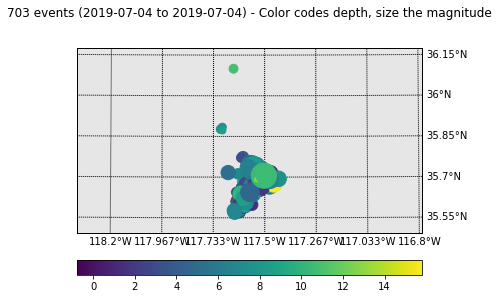

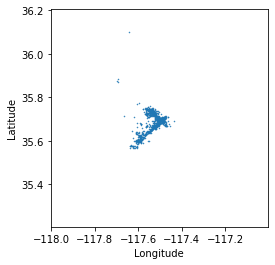

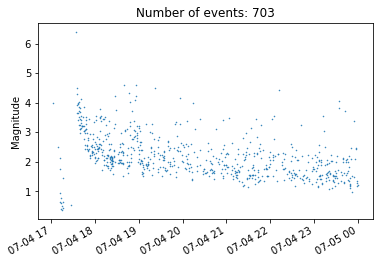

In [57]:
download_events(root_dir("config.pkl"), root_dir("events.csv"))

In [50]:
download_events_op = comp.func_to_container_op(download_events, 
                                               base_image='python:3.8',
                                               packages_to_install= [
                                                  "obspy",
                                                  "pandas",
#                                                   "matplotlib"
                                               ])

In [58]:
def download_stations(config_pkl: InputPath("pickle"),
                      station_csv: OutputPath(str),
                      station_pkl: OutputPath("pickle")):
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    from collections import defaultdict
    import pandas as pd
#     import matplotlib
#     matplotlib.use("agg")
#     import matplotlib.pyplot as plt
    
    with open(config_pkl, "rb") as fp:
        config = pickle.load(fp)

    print("Network:", ",".join(config["networks"]))
    ####### Download stations ########
    stations = Client(config["client"]).get_stations(network = ",".join(config["networks"]),
                                           station = "*",
                                           starttime=config["starttime"],
                                           endtime=config["endtime"],
                                           minlongitude=config["xlim_degree"][0],
                                           maxlongitude=config["xlim_degree"][1],
                                           minlatitude=config["ylim_degree"][0],
                                           maxlatitude=config["ylim_degree"][1],
                                           channel=config["channels"],
                                           level="response")#,
#                                            filename="stations.xml")

#     stations = obspy.read_inventory("stations.xml")
    print("Number of stations: {}".format(sum([len(x) for x in stations])))
    # stations.plot('local', outfile="stations.png")
    stations.plot('local')
    
    ####### Save stations ########
    station_locs = defaultdict(dict)
    for network in stations:
        for station in network:
            for chn in station:
                sid = f"{network.code}.{station.code}.{chn.location_code}.{chn.code[:-1]}"
                if sid in station_locs:
                    station_locs[sid]["component"] += f",{chn.code[-1]}"
                    station_locs[sid]["response"] += f",{chn.response.instrument_sensitivity.value:.2f}"
                else:
                    component = f"{chn.code[-1]}"
                    response = f"{chn.response.instrument_sensitivity.value:.2f}"
                    dtype = chn.response.instrument_sensitivity.input_units.lower()
                    tmp_dict = {}
                    tmp_dict["longitude"], tmp_dict["latitude"], tmp_dict["elevation(m)"] = chn.longitude, chn.latitude, chn.elevation
                    tmp_dict["component"], tmp_dict["response"], tmp_dict["unit"] = component, response, dtype
                    station_locs[sid] = tmp_dict
                    
    station_locs = pd.DataFrame.from_dict(station_locs, orient='index')
    station_locs.to_csv(station_csv,
                        sep="\t", float_format="%.3f",
                        index_label="station",
                        columns=["longitude", "latitude", "elevation(m)", "unit", "component", "response"])

    with open(station_pkl, "wb") as fp:
        pickle.dump(stations, fp)
        
#     ####### Plot stations ########
    plt.figure()
    plt.plot(station_locs["longitude"], station_locs["latitude"], "^", label="Stations")
    plt.xlabel("X (km)")
    plt.ylabel("Y (km)")
    plt.axis("scaled")
    plt.xlim(config["xlim_degree"])
    plt.ylim(config["ylim_degree"])
    plt.legend()
    plt.title(f"Number of stations: {len(station_locs)}")
#     plt.savefig(os.path.join(data_path, "stations_loc.png"))
    plt.show()

Network: *
Number of stations: 23


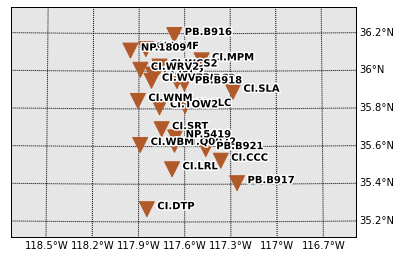

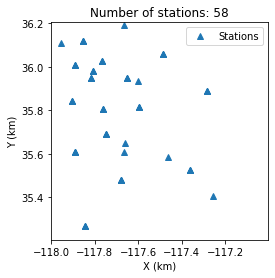

In [59]:
download_stations(root_dir("config.pkl"), root_dir("stations.csv"), root_dir("stations.pkl"))

In [60]:
download_stations_op = comp.func_to_container_op(download_stations, 
                                                 base_image='python:3.8',
                                                 packages_to_install= [
                                                     "obspy",
                                                     "pandas",
#                                                      "matplotlib"
                                                 ])

In [61]:
def download_waveform(i: int, 
                      index_pkl: InputPath("pickle"),
                      config_pkl: InputPath("pickle"),
                      datetime_pkl: InputPath("pickle"),
                      station_pkl: InputPath("pickle"),
                      fname_csv: OutputPath(str),
                      data_path:str = "/tmp"
#                       bucket_name:str = "waveforms",
#                       s3_url:str = "localhost:9000", 
#                       secure:bool = True
                     ) -> str:
    
    import pickle, os
    import obspy
    from obspy.clients.fdsn import Client
    import time
    import threading
    lock = threading.Lock()
    
#     from minio import Minio
#     minioClient = Minio(s3_url,
#                   access_key='minio',
#                   secret_key='minio123',
#                   secure=secure)
    
#     if not minioClient.bucket_exists(bucket_name):
#         minioClient.make_bucket(bucket_name)

    with open(index_pkl, "rb") as fp:
        index = pickle.load(fp)
    idx = index[i]
    with open(config_pkl, "rb") as fp:
        config = pickle.load(fp)
    with open(datetime_pkl, "rb") as fp:
        tmp = pickle.load(fp)
        starttimes = tmp["starttimes"]
        interval = tmp["interval"]
    with open(station_pkl, "rb") as fp:
        stations = pickle.load(fp)
    
    waveform_dir = os.path.join(data_path, "waveforms")
    if not os.path.exists(waveform_dir):
        os.makedirs(waveform_dir)
        
    ####### Download data ########
    client = Client(config["client"])
    fname_list = ["fname"]
    
    def download(i):
#     for i in idx: 
        starttime = obspy.UTCDateTime(starttimes[i]) 
        endtime = starttime + interval
        fname = "{}.mseed".format(starttime.datetime.strftime("%Y-%m-%dT%H:%M:%S"))
#         if not overwrite:
        if os.path.exists(os.path.join(waveform_dir, fname)):
            print(f"{fname} exists")
            fname_list.append(fname)
#             continue
            return
        max_retry = 10
        stream = obspy.Stream()
        print(f"{fname} download starts")
        for network in stations:
            for station in network:
                print(f"********{network.code}.{station.code}********")
                retry = 0
                while retry < max_retry:
                    try:
                        tmp = client.get_waveforms(network.code, station.code, "*", config["channels"], starttime, endtime)
#                         for trace in tmp:
#                             if trace.stats.sampling_rate != 100:
#                                 print(trace)
#                                 trace = trace.interpolate(100, method="linear")
#                             trace = trace.detrend("spline", order=2, dspline=5*trace.stats.sampling_rate)
#                             stream.append(trace)
                        stream += tmp
                        break
                    except Exception as err:
                        print("Error {}.{}: {}".format(network.code, station.code, err))
                        message = "No data available for request."
                        if str(err)[:len(message)] == message:
                            break
                        retry += 1
                        time.sleep(1)
                        continue
                if retry == max_retry:
                    print(f"{fname}: MAX {max_retry} retries reached : {network.code}.{station.code} with error: {err}")
        
#         stream = stream.merge(fill_value=0)
#         stream = stream.trim(starttime, endtime, pad=True, fill_value=0)
        
        stream.write(os.path.join(waveform_dir, fname))
        print(f"{fname} download succeeds")
#         minioClient.fput_object(bucket_name, fname, os.path.join(waveform_dir, fname))
        lock.acquire()
        fname_list.append(fname)
        lock.release()
    
    threads = []
    MAX_THREADS = 8
    for i in idx:
        t = threading.Thread(target=download, args=(i,))
        t.start()
        time.sleep(0.01)
        threads.append(t)
        if i%MAX_THREADS == MAX_THREADS-1:
            for t in threads:
                t.join()
            threads = []
    for t in threads:
        t.join()

    with open(fname_csv, "w") as fp:
        fp.write("\n".join(fname_list))

    return waveform_dir

In [62]:
waveform_path = download_waveform(0, root_dir("index.pkl"), root_dir("config.pkl"), root_dir("datetimes.pkl"), root_dir("stations.pkl"), root_dir("fname.csv"), data_path=root_dir(""))

2019-07-04T17:00:00.mseed download starts
********CI.CCC********
2019-07-04T18:00:00.mseed download starts
********CI.CCC********
2019-07-04T19:00:00.mseed download starts
********CI.CCC********
2019-07-04T20:00:00.mseed download starts
********CI.CCC********
2019-07-04T21:00:00.mseed download starts
********CI.CCC********
2019-07-04T22:00:00.mseed download starts
********CI.CCC********
2019-07-04T23:00:00.mseed download starts
********CI.CCC********
********CI.CLC********
********CI.CLC********
********CI.CLC********
********CI.CLC********
********CI.CLC********
********CI.CLC********
********CI.CLC********
********CI.DTP********
********CI.DTP********
********CI.DTP********
********CI.DTP********
********CI.DTP********
********CI.DTP********
********CI.DTP********
********CI.JRC2********
********CI.JRC2********
********CI.JRC2********
********CI.JRC2********
********CI.JRC2********
********CI.JRC2********
********CI.JRC2********
********CI.LRL********
********CI.LRL********
********C

In [63]:
download_waveform_op = comp.func_to_container_op(download_waveform, 
                                                 base_image='python:3.8',
                                                 packages_to_install= [
                                                     "obspy",
#                                                      "minio"
                                                 ])

In [64]:
def phasenet_op(data_path: str, 
                data_list: str, 
                stations: str):

    return dsl.ContainerOp(name='PhaseNet picking',
                           image="zhuwq0/phasenet:latest",
                           command=['python'],
                           arguments=[
                             'predict.py',
                             '--model', "model/190703-214543",
                             '--data_dir', data_path,
                             '--data_list', dsl.InputArgumentPath(data_list),
                             '--stations', dsl.InputArgumentPath(stations),
#                              '--result_dir', "results",
                             '--input_mseed',
                             '--amplitude'
                             ],
                           file_outputs = {"picks": "/opt/results/picks.json"}
                         )

In [76]:
command = f"python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_list={root_dir('fname.csv')} --data_dir={root_dir('waveforms')} --stations={root_dir('stations.csv')} --result_dir={root_dir('phasenet')} --format=mseed_array --amplitude"
print(command)
!{command}

python PhaseNet/phasenet/predict.py --model=PhaseNet/model/190703-214543 --data_list=Ridgecrest/fname.csv --data_dir=Ridgecrest/waveforms --stations=Ridgecrest/stations.csv --result_dir=Ridgecrest/phasenet --format=mseed_array --amplitude
           station  longitude  ...  component                                response
0       CI.CCC..BH   -117.365  ...      E,N,Z  627368000.00,627368000.00,627368000.00
1       CI.CCC..HH   -117.365  ...      E,N,Z  627368000.00,627368000.00,627368000.00
2       CI.CCC..HN   -117.365  ...      E,N,Z           213979.00,214322.00,213808.00
3       CI.CLC..BH   -117.598  ...      E,N,Z  627368000.00,627368000.00,627368000.00
4       CI.CLC..HH   -117.598  ...      E,N,Z  627368000.00,627368000.00,627368000.00
5       CI.CLC..HN   -117.598  ...      E,N,Z           213945.00,213808.00,213740.00
6       CI.DTP..BH   -117.846  ...      E,N,Z  627368000.00,627368000.00,627368000.00
7       CI.DTP..HH   -117.846  ...      E,N,Z  627368000.00,627368000.00,

In [79]:
def gmma(i: int,
         index_pkl: InputPath("pickle"),
         config_pkl: InputPath("pickle"),
         pick_json: InputPath("json"),
         station_csv: InputPath(str),
         catalog_csv: OutputPath(str),
         picks_csv: OutputPath(str),
         bucket_name:str = "catalogs",
         s3_url:str = "localhost:9000", 
         secure:bool = True) -> str:
    
    import pandas as pd
    from datetime import datetime, timedelta
    from gmma import mixture
    import numpy as np
    from sklearn.cluster import DBSCAN 
    from datetime import datetime, timedelta
    import os
    import json
    import pickle
    from tqdm import tqdm

    to_seconds = lambda t: t.timestamp(tz="UTC")
    from_seconds = lambda t: pd.Timestamp.utcfromtimestamp(t).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3]
    # to_seconds = lambda t: datetime.strptime(t, "%Y-%m-%dT%H:%M:%S.%f").timestamp()
    # from_seconds = lambda t: [datetime.utcfromtimestamp(x).strftime("%Y-%m-%dT%H:%M:%S.%f")[:-3] for x in t]

    def convert_picks_csv(picks, stations, config):
        t = picks["timestamp"].apply(lambda x: x.timestamp()).to_numpy()
        a = picks["amp"].apply(lambda x: np.log10(x*1e2)).to_numpy()
        data = np.stack([t, a]).T
        meta = pd.merge(stations, picks["id"], on="id")
        locs = meta[config["dims"]].to_numpy()
        phase_type = picks["type"].apply(lambda x: x.lower()).to_numpy()
        phase_weight = picks["prob"].to_numpy()[:,np.newaxis]
        return data, locs, phase_type, phase_weight

    def association(data, locs, phase_type, phase_weight, num_sta, pick_idx, event_idx0, config, pbar=None):

        db = DBSCAN(eps=config["dbscan_eps"], min_samples=config["dbscan_min_samples"]).fit(np.hstack([data[:,0:1], locs[:,:2]/6.0]))#.fit(data[:,0:1])
        labels = db.labels_
        unique_labels = set(labels)
        events = []
        preds = []
        probs = []

        assignment = []
        for k in unique_labels:
            if k == -1:
                continue

            class_mask = (labels == k)
            data_ = data[class_mask]
            locs_ = locs[class_mask]
            phase_type_ = phase_type[class_mask]
            phase_weight_ = phase_weight[class_mask]
            pick_idx_ = pick_idx[class_mask]

            if pbar is not None:
                pbar.set_description(f"Process {len(data_)} picks")

            time_range = max(data_[:,0].max() - data_[:,0].min(), 1)

            num_event_loc_init = 5
            num_event_init = min(max(int(len(data_)/min(num_sta, 20) * config["oversample_factor"]), 1), len(data)//num_event_loc_init)
            x0, xn = config["x(km)"]
            y0, yn = config["y(km)"]
            x1, y1 = np.mean(config["x(km)"]), np.mean(config["y(km)"])
            event_loc_init = [((x0+x1)/2, (y0+y1)/2), ((x0+x1)/2, (yn+y1)/2), ((xn+x1)/2, (y0+y1)/2), ((xn+x1)/2, (yn+y1)/2), (x1, y1)]
            num_event_time_init = max(num_event_init//num_event_loc_init, 1)
            centers_init = np.vstack([np.vstack([np.ones(num_event_time_init) * x, 
                                                 np.ones(num_event_time_init) * y,
                                                 np.zeros(num_event_time_init),
                                                 np.linspace(data_[:,0].min()-0.1*time_range, data_[:,0].max()+0.1*time_range, num_event_time_init)]).T
                                      for x, y in event_loc_init])

    #         num_event_init = min(max(int(len(data_)/min(num_sta, 20) * config["oversample_factor"]), 1), len(data))
    #         centers_init = np.vstack([np.ones(num_event_init)*np.mean(stations["x(km)"]),
    #                                   np.ones(num_event_init)*np.mean(stations["y(km)"]),
    #                                   np.zeros(num_event_init),
    #                                   np.linspace(data_[:,0].min()-0.1*time_range, data_[:,0].max()+0.1*time_range, num_event_init)]).T

            mean_precision_prior = 0.1/time_range
            if not config["use_amplitude"]:
                covariance_prior = np.array([[1]]) * 5
                data = data[:,0:1]
            else:
                covariance_prior = np.array([[1,0],[0,1]]) * 5

            gmm = mixture.BayesianGaussianMixture(n_components=len(centers_init), 
                                                  weight_concentration_prior=1/len(centers_init),
                                                  mean_precision_prior=mean_precision_prior,
                                                  covariance_prior=covariance_prior,
                                                  init_params="centers",
                                                  centers_init=centers_init.copy(), 
                                                  station_locs=locs_, 
                                                  phase_type=phase_type_, 
                                                  phase_weight=phase_weight_,
                                                  loss_type="l1",
                                                  bounds=config["bfgs_bounds"],
                                                  max_covar=20**2,
                                                  ).fit(data_) 

            pred = gmm.predict(data_) 
            prob_matrix = gmm.predict_proba(data_)
            prob_eq = prob_matrix.mean(axis=0)
    #             prob = prob_matrix[range(len(data_)), pred]
    #             score = gmm.score(data_)
    #             score_sample = gmm.score_samples(data_)
            prob = np.exp(gmm.score_samples(data_))

            idx = np.array([True if len(data_[pred==i, 0]) >= config["min_picks_per_eq"] else False for i in range(len(prob_eq))]) #& (prob_eq > 1/num_event) #& (sigma_eq[:, 0,0] < 40)

            time = gmm.centers_[idx, len(config["dims"])]
            loc = gmm.centers_[idx, :len(config["dims"])]
            if config["use_amplitude"]:
                mag = gmm.centers_[idx, len(config["dims"])+1]
            sigma_eq = gmm.covariances_[idx,...]

            for i in range(len(time)):
                tmp = {"time(s)": time[i],
                       "magnitude": mag[i],
                       "sigma": sigma_eq[i].tolist()}
                for j, k in enumerate(config["dims"]):
                    tmp[k] = loc[i][j]
                events.append(tmp)

            for i in range(len(pick_idx_)):
                assignment.append((pick_idx_[i], pred[i]+event_idx0, prob[i]))

            event_idx0 += len(time)

        return events, assignment
    
    catalog_dir = os.path.join("/tmp/", bucket_name)
    if not os.path.exists(catalog_dir):
        os.makedirs(catalog_dir)
        
    with open(index_pkl, "rb") as fp:
        index = pickle.load(fp)
    idx = index[i]

    with open(config_pkl, "rb") as fp:
        config = pickle.load(fp)
    
    ## read picks
    picks = pd.read_json(pick_json)
    picks["time_idx"] = picks["timestamp"].apply(lambda x: x.strftime("%Y-%m-%dT%H")) ## process by hours

    ## read stations
    stations = pd.read_csv(station_csv, delimiter="\t")
    stations = stations.rename(columns={"station":"id"})
    stations["x(km)"] = stations["longitude"].apply(lambda x: (x - config["center"][0])*config["degree2km"])
    stations["y(km)"] = stations["latitude"].apply(lambda x: (x - config["center"][1])*config["degree2km"])
    stations["z(km)"] = stations["elevation(m)"].apply(lambda x: -x/1e3)

    ### setting GMMA configs
    config["dims"] = ['x(km)', 'y(km)', 'z(km)']
    config["use_dbscan"] = True
    config["use_amplitude"] = True
    config["x(km)"] = (np.array(config["xlim_degree"])-np.array(config["center"][0]))*config["degree2km"]
    config["y(km)"] = (np.array(config["ylim_degree"])-np.array(config["center"][1]))*config["degree2km"]
    config["z(km)"] = (0, 20)
    # DBSCAN
    config["bfgs_bounds"] = ((config["x(km)"][0]-1, config["x(km)"][1]+1), #x
                            (config["y(km)"][0]-1, config["y(km)"][1]+1), #y
                            (0, config["z(km)"][1]+1), #x
                            (None, None)) #t
    config["dbscan_eps"] = min(np.sqrt((stations["x(km)"].max()-stations["x(km)"].min())**2 +
                                       (stations["y(km)"].max()-stations["y(km)"].min())**2)/(6.0/1.75), 10) #s
    config["dbscan_min_samples"] = min(len(stations), 5)
    # Filtering
    config["min_picks_per_eq"] = min(len(stations)//2, 10)
    config["oversample_factor"] = min(len(stations)//2, 10)
    print("Config: ", config)

    ## run GMMA association
    catalogs = []
    pbar = tqdm(sorted(list(set(picks["time_idx"]))))
    event_idx0 = 0 ## current earthquake index
    assignments = []
    if (len(picks) > 0) and (len(picks) < 5000):
        data, locs, phase_type, phase_weight = convert_picks_csv(picks, stations, config)
        catalogs, assignments = association(data, locs, phase_type, phase_weight, len(stations), picks.index.to_numpy(), event_idx0, config, pbar)
    else:
        for i, hour in enumerate(pbar):
            picks_ = picks[picks["time_idx"] == hour]
            if len(picks_) == 0:
                continue
            data, locs, phase_type, phase_weight = convert_picks_csv(picks_, stations, config)
            catalog, assign = association(data, locs, phase_type, phase_weight, len(stations), picks_.index.to_numpy(), event_idx0, config, pbar)
            event_idx0 += len(catalog)
            catalogs.extend(catalog)
            assignments.extend(assign)

    ## create catalog
    catalogs = pd.DataFrame(catalogs, columns=["time(s)"]+config["dims"]+["magnitude", "sigma"])
    catalogs["time"] = catalogs["time(s)"].apply(lambda x: from_seconds(x))
    catalogs["longitude"] = catalogs["x(km)"].apply(lambda x: x/config["degree2km"] + config["center"][0])
    catalogs["latitude"] = catalogs["y(km)"].apply(lambda x: x/config["degree2km"] + config["center"][1])
    catalogs["depth(m)"] = catalogs["z(km)"].apply(lambda x: x*1e3)
    catalogs["event_idx"] = range(event_idx0)
    if config["use_amplitude"]:
        catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f},{x[1][1]:.3f},{x[0][1]:.3f}")
    else:
        catalogs["covariance"] = catalogs["sigma"].apply(lambda x: f"{x[0][0]:.3f}")
    with open(catalog_csv, 'w') as fp:
        catalogs.to_csv(fp, sep="\t", index=False, 
                        float_format="%.3f",
                        date_format='%Y-%m-%dT%H:%M:%S.%f',
                        columns=["time", "magnitude", "longitude", "latitude", "depth(m)", "covariance", "event_idx"])

    ## add assignment to picks
    assignments = pd.DataFrame(assignments, columns=["pick_idx", "event_idx", "prob_gmma"])
    picks = picks.join(assignments.set_index("pick_idx")).fillna(-1).astype({'event_idx': int})
    with open(picks_csv, 'w') as fp:
        picks.to_csv(fp, sep="\t", index=False, 
                        date_format='%Y-%m-%dT%H:%M:%S.%f',
                        columns=["id", "timestamp", "type", "prob", "amp", "event_idx", "prob_gmma"])
    
    ## upload to s3 bucket
    try:
        from minio import Minio
        minioClient = Minio(s3_url,
                      access_key='minio',
                      secret_key='minio123',
                      secure=secure)
        if not minioClient.bucket_exists(bucket_name):
            minioClient.make_bucket(bucket_name)
            
        with open(os.path.join(catalog_dir, f"catalog_{idx[0]:04d}.csv"), 'w') as fp:
            catalogs.to_csv(fp, sep="\t", index=False, 
                            float_format="%.3f",
                            date_format='%Y-%m-%dT%H:%M:%S.%f',
                            columns=["time", "magnitude", "longitude", "latitude", "depth(m)"])
        minioClient.fput_object(bucket_name, f"catalog_{i:04d}.csv", os.path.join(catalog_dir, f"catalog_{i:04d}.csv"))
    except Exception as e:
        print("ERROR: can not access minio service!")
    
    return f"catalog_{i:04d}.csv"
    

In [80]:
catalog = gmma(0, root_dir("index.pkl"), root_dir("config.pkl"), root_dir("phasenet/picks.json"), root_dir("stations.csv"), root_dir("catalog.csv"), root_dir("picks.csv"))
#                     bucket_name="catalogs", s3_url="localhost:9000", secure=False)

Process 98 picks:   0%|          | 0/7 [00:00<?, ?it/s]

Config:  {'center': (-117.504, 35.705), 'xlim_degree': [-118.004, -117.004], 'ylim_degree': [35.205, 36.205], 'degree2km': 111.19492474777779, 'starttime': datetime.datetime(2019, 7, 4, 17, 0), 'endtime': datetime.datetime(2019, 7, 5, 0, 0), 'networks': ['*'], 'channels': 'HH*,BH*,EH*,HN*', 'client': 'SCEDC', 'dims': ['x(km)', 'y(km)', 'z(km)'], 'use_dbscan': True, 'use_amplitude': True, 'x(km)': array([-55.59746237,  55.59746237]), 'y(km)': array([-55.59746237,  55.59746237]), 'z(km)': (0, 20), 'bfgs_bounds': ((-56.597462373888895, 56.597462373888895), (-56.597462373888895, 56.597462373888895), (0, 21), (None, None)), 'dbscan_eps': 10, 'dbscan_min_samples': 5, 'min_picks_per_eq': 10, 'oversample_factor': 10}


Process 36 picks: 100%|██████████| 7/7 [32:04<00:00, 274.99s/it]  


ERROR: can not access minio service!


In [ ]:
gmma_op = comp.func_to_container_op(gmma, 
                                    base_image='python:3.8',
                                    packages_to_install= [
                                         "pandas",
                                         "numpy",
                                         "scikit-learn",
                                         "minio",
                                         "gmma"
                                    ])

In [ ]:
def combine_catalog(catalog_csv: OutputPath(str),
                    bucket_name:str = "catalogs",
                    s3_url:str = "minio-service:9000", 
                    secure:bool = True):
     
    import pandas as pd
    from glob import glob
    import os
    
    from minio import Minio
    minioClient = Minio(s3_url,
                  access_key='minio',
                  secret_key='minio123',
                  secure=secure)
    objects = minioClient.list_objects(bucket_name, recursive=True)
    
    tmp_path = lambda x: os.path.join("/tmp/", x)
    for obj in objects:
        minioClient.fget_object(bucket_name, obj._object_name, tmp_path(obj._object_name))
    
    files_catalog = sorted(glob(tmp_path("catalog_*.csv")))

    if len(files_catalog) > 0:
        combined_catalog = pd.concat([pd.read_csv(f, sep="\t", dtype=str) for f in files_catalog]).sort_values(by="time")
        combined_catalog.to_csv(tmp_path("combined_catalog.csv"), sep="\t", index=False)
        minioClient.fput_object(bucket_name, f"combined_catalog.csv", tmp_path("combined_catalog.csv"))
        with open(catalog_csv, "w") as fout:
            with open(tmp_path("combined_catalog.csv"), "r") as fin:
                for line in fin:
                    fout.write(line)
    else:
        with open(catalog_csv, "w") as fout:
            pass
        print("No events.csv found!")


In [ ]:
# combine_catalog("catalog.csv", bucket_name="catalogs", s3_url="localhost:9000", secure=True)

In [ ]:
combine_op = comp.func_to_container_op(combine_catalog, 
                                       base_image='python:3.8',
                                       packages_to_install= [
                                           "pandas",
                                           "minio"
                                       ])

In [ ]:
# Define the pipeline
@dsl.pipeline(name='QuakeFlow', description='')
def quakeflow_pipeline(data_path:str = "/tmp/", 
                       bucket_catalog:str = "catalogs",
                       s3_url:str="minio-service:9000", 
                       secure:bool=False):
    
    
    config = config_op()

    events = download_events_op(config.outputs["config_pkl"])
    
    stations = download_stations_op(config.outputs["config_pkl"])

    with kfp.dsl.ParallelFor(config.outputs["output"]) as i:
        
        vop_ = dsl.VolumeOp(name="Create volume",
                            resource_name="data_volume", 
                            size="10Gi", 
                            modes=dsl.VOLUME_MODE_RWO)
        
        download_op_ = download_waveform_op(i, 
                                            config.outputs["index_pkl"], 
                                            config.outputs["config_pkl"], 
                                            config.outputs["datetime_pkl"], 
                                            stations.outputs["station_pkl"],
                                            data_path = data_path
                                           ).add_pvolumes({data_path: vop_.volume})

        phasenet_op_ = phasenet_op(download_op_.outputs["Output"], 
                                   download_op_.outputs["fname_csv"], 
                                   stations.outputs["station_csv"]
                                   ).add_pvolumes({data_path: download_op_.pvolume})
#         phasenet_op_.execution_options.caching_strategy.max_cache_staleness = "P0D"

        gmma_op_ = gmma_op(i,
                           config.outputs["index_pkl"],
                           config.outputs["config_pkl"],
                           phasenet_op_.outputs["picks"],
                           stations.outputs["station_csv"],
                           bucket_name = "catalogs",
                           s3_url = s3_url,
                           secure = secure
                           ).add_pvolumes({data_path: phasenet_op_.pvolume})

    combine_op_ = combine_op(bucket_name = "catalogs", s3_url=s3_url, secure=secure).after(gmma_op_)
    combine_op_.execution_options.caching_strategy.max_cache_staleness = "P0D"

In [ ]:
# client = kfp.Client(host='553ab00ece5a86e5-dot-us-west1.pipelines.googleusercontent.com')

In [ ]:
experiment_name = 'QuakeFlow'
pipeline_func = quakeflow_pipeline
run_name = pipeline_func.__name__ + '_run'

arguments = {"data_path": "/tmp/",
             "bucket_catalog": "catalogs",
             "s3_url": "minio-service:9000",
             "secure": False
             }

# kfp.compiler.Compiler().compile(pipeline_func, '{}.zip'.format(experiment_name))
# results = client.create_run_from_pipeline_func(pipeline_func, 
#                                                experiment_name=experiment_name, 
#                                                run_name=run_name, 
#                                                arguments=arguments)